In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, welch
from scipy.stats import skew, kurtosis, entropy
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [3]:
import pandas as pd
from scipy.io import arff  # For loading .arff files

h_train_data, h_train_meta = arff.loadarff('../data/EOGHorizontalSignal_TRAIN.arff')
hEOG_train = pd.DataFrame(h_train_data)

h_test_data, h_test_meta = arff.loadarff('../data/EOGHorizontalSignal_TEST.arff')
hEOG_test = pd.DataFrame(h_test_data)

v_train_data, v_train_meta = arff.loadarff('../data/EOGVerticalSignal_TRAIN.arff')
vEOG_train = pd.DataFrame(v_train_data)

v_test_data, v_test_meta = arff.loadarff('../data/EOGVerticalSignal_TEST.arff')
vEOG_test = pd.DataFrame(v_test_data)

In [4]:
hEOG_train['target'] = hEOG_train['target'].apply(lambda x: int(x.decode('utf-8')))
vEOG_train['target'] = vEOG_train['target'].apply(lambda x: int(x.decode('utf-8')))
hEOG_test['target'] = hEOG_test['target'].apply(lambda x: int(x.decode('utf-8')))
vEOG_test['target'] = vEOG_test['target'].apply(lambda x: int(x.decode('utf-8')))

In [5]:
# Assuming both have the same target
y_train = hEOG_train['target'].copy()
y_test = hEOG_test['target'].copy()

# Optionally, concatenate the horizontal and vertical data along columns (axis=1)
X_train_combined = pd.concat([hEOG_train.drop(columns=['target']), vEOG_train.drop(columns=['target'])], axis=1)
X_test_combined = pd.concat([hEOG_test.drop(columns=['target']), vEOG_test.drop(columns=['target'])], axis=1)

In [12]:
X_train_combined.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att1241,att1242,att1243,att1244,att1245,att1246,att1247,att1248,att1249,att1250
0,0.47769,0.60965,0.44162,0.57358,0.70555,0.83751,0.96947,1.1014,1.2334,0.96536,...,-113.3100,-113.4100,-113.5000,-114.3900,-114.4800,-113.7700,-113.070,-113.1600,-112.8500,-112.9400
1,2.33700,2.35920,3.08140,3.10350,2.42570,2.44790,2.17000,2.4922,2.5144,2.53650,...,108.3900,108.5600,108.5300,108.5000,108.4700,108.4500,108.420,108.3900,108.1600,108.1300
2,-10.24000,-10.21900,-10.19800,-10.37700,-10.85600,-10.93600,-10.81500,-10.3940,-10.3730,-10.35200,...,-34.9360,-35.1190,-35.3010,-35.4840,-35.6660,-34.9490,-35.132,-35.3140,-34.5970,-34.7800
3,9.99690,9.87520,9.75350,9.63190,10.51000,11.68900,12.06700,11.9450,12.2240,12.80200,...,-173.8600,-174.0700,-173.6800,-173.8900,-174.7000,-174.7100,-174.920,-175.1300,-174.7400,-174.3500
4,13.86800,13.07200,12.17500,11.67900,11.28200,10.88600,10.58900,10.0930,9.6961,9.29950,...,2.0864,1.8044,1.9223,2.0402,2.1582,2.2761,2.394,2.5119,2.6299,2.7478


In [10]:
import numpy as np
from scipy.signal import butter, filtfilt

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Parameters for filtering
fs = 1000  # Sampling rate (1 kHz)
lowcut = 0.1  # Low frequency cut (for removing drift)
highcut = 30.0  # High frequency cut (for noise reduction)

# Apply filtering on the train EOG signal
hEOG_train_filtered = hEOG_train.drop(columns=['target']).apply(lambda x: butter_bandpass_filter(x, lowcut, highcut, fs))
vEOG_train_filtered = vEOG_train.drop(columns=['target']).apply(lambda x: butter_bandpass_filter(x, lowcut, highcut, fs))
# Apply filtering on the test EOG signal
hEOG_test_filtered = hEOG_test.drop(columns=['target']).apply(lambda x: butter_bandpass_filter(x, lowcut, highcut, fs))
vEOG_test_filtered = vEOG_test.drop(columns=['target']).apply(lambda x: butter_bandpass_filter(x, lowcut, highcut, fs))


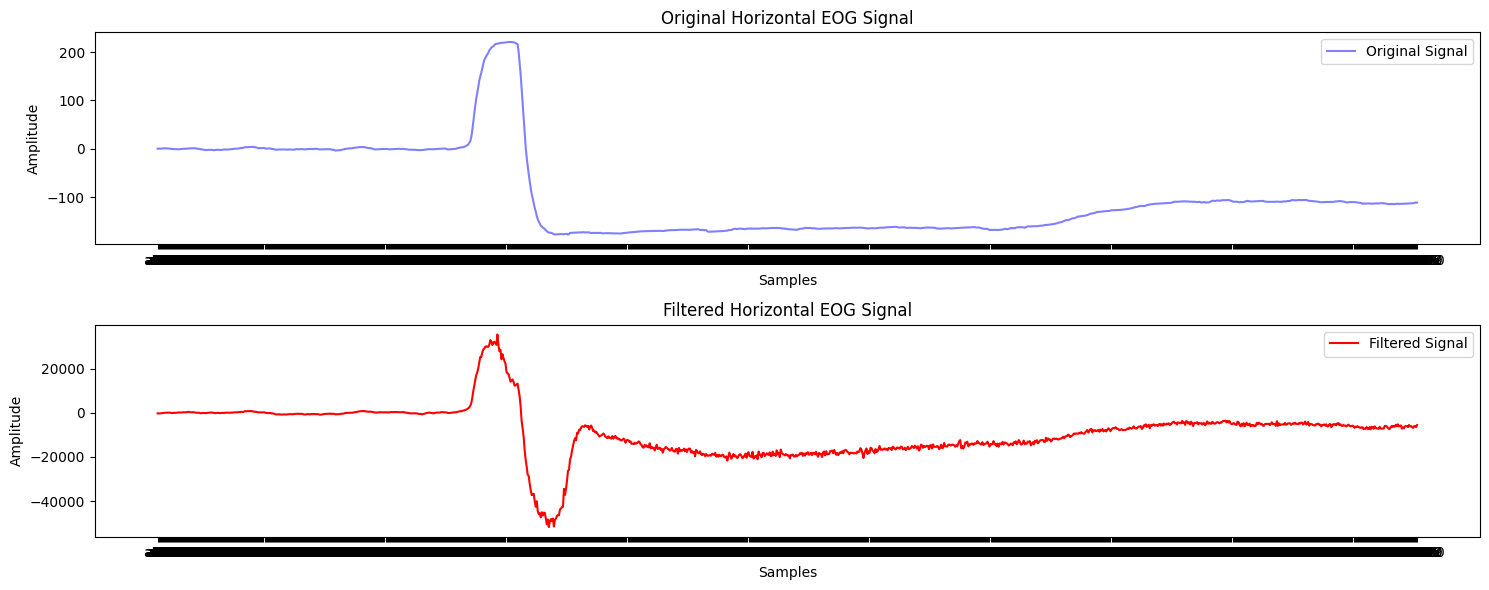

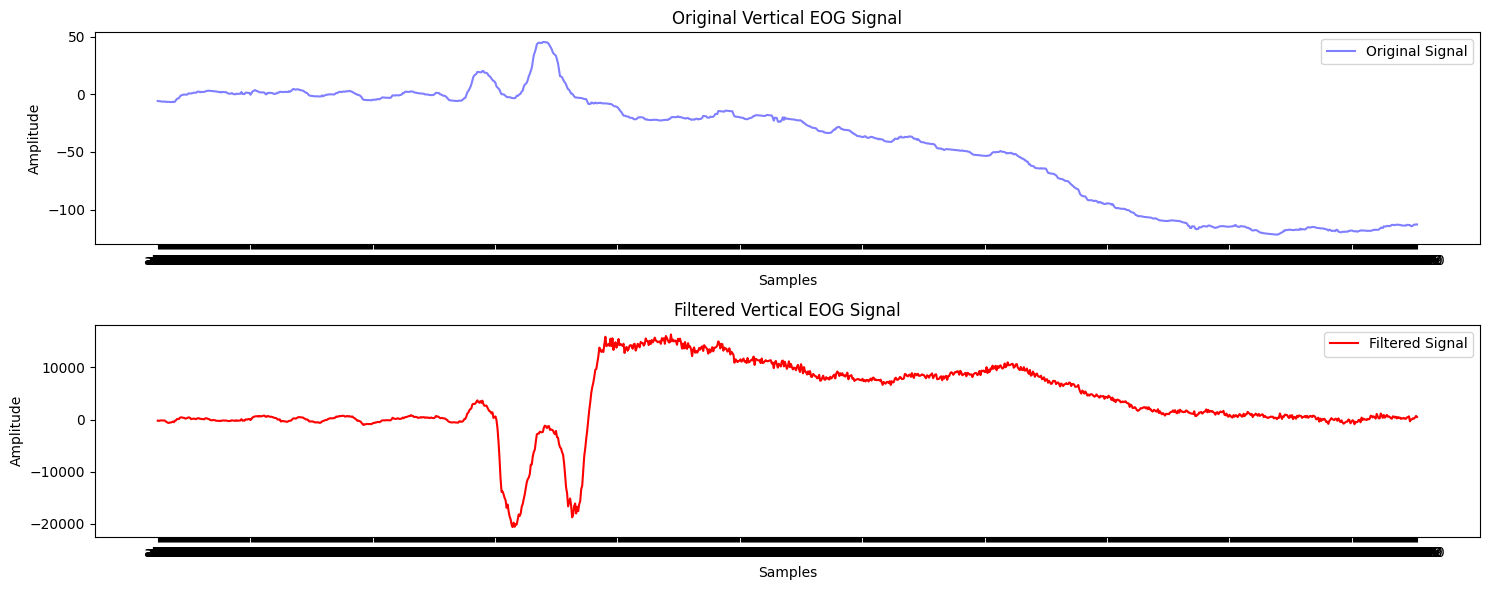

In [11]:
import matplotlib.pyplot as plt

# Function to plot the filtered EOG signal
def plot_filtered_signal(original_signal, filtered_signal, signal_type):
    plt.figure(figsize=(15, 6))

    # Plot original signal
    plt.subplot(2, 1, 1)
    plt.plot(original_signal, color='blue', alpha=0.5, label='Original Signal')
    plt.title(f'Original {signal_type} EOG Signal')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.legend()

    # Plot filtered signal
    plt.subplot(2, 1, 2)
    plt.plot(filtered_signal, color='red', label='Filtered Signal')
    plt.title(f'Filtered {signal_type} EOG Signal')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot filtered horizontal EOG signal
plot_filtered_signal(hEOG_train.drop(columns=['target']).iloc[0], hEOG_train_filtered.iloc[0], 'Horizontal')

# Plot filtered vertical EOG signal
plot_filtered_signal(vEOG_train.drop(columns=['target']).iloc[0], vEOG_train_filtered.iloc[0], 'Vertical')


In [13]:
# Reshape horizontal and vertical EOG signals for LSTM
def reshape_data(data):
    # Assume data has shape (n_samples, n_timesteps, n_features)
    return data.values.reshape((data.shape[0], 1250, 1))  # 1250 timesteps, 1 feature

# Prepare horizontal EOG training and testing data
hEOG_train_reshaped = reshape_data(hEOG_train_filtered)
hEOG_test_reshaped = reshape_data(hEOG_test_filtered)

# Prepare vertical EOG training and testing data
vEOG_train_reshaped = reshape_data(vEOG_train_filtered)
vEOG_test_reshaped = reshape_data(vEOG_test_filtered)

# Combine horizontal and vertical data
X_train = np.concatenate((hEOG_train_reshaped, vEOG_train_reshaped), axis=2)
X_test = np.concatenate((hEOG_test_reshaped, vEOG_test_reshaped), axis=2)

# Prepare target variable
y_train = hEOG_train['target'].values  # Assuming target is the same for horizontal and vertical
y_test = hEOG_test['target'].values


In [16]:
X_train.shape

(362, 1250, 2)

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, LSTM, Bidirectional, Input

# Define the LSTM model
def create_lstm_model(input_shape, num_classes):
    model = Sequential()
    model.add(Input(shape=input_shape, name='input layer'))
    model.add(Bidirectional(GRU(64, activation='relu', return_sequences=True, name='layer1')))
    model.add(GRU(32,activation='relu', name='layer2'))
    model.add(Dense(32, activation='relu', name='layer3'))
    model.add(Dense(num_classes, activation='softmax' ,name='layer4'))  # Use softmax for multi-class classification
    return model

# Define input shape and number of classes
input_shape = (X_train.shape[1], X_train.shape[2])  # 1250 timesteps, 2 features (horizontal and vertical EOG)
num_classes = 12  # Number of classes

# Create the model
model = create_lstm_model(input_shape, num_classes)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy for integer labels
              optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
              metrics=['accuracy'])
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_6 (Bidirectional) │ (None, 1250, 128)      │        26,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer2 (GRU)                    │ (None, 32)             │        15,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer3 (Dense)                  │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer4 (Dense)                  │ (None, 12)             │           396 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,116 (168.42 KB)

 Trainable params: 43,116 (168.42 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Adjust labels to be zero-indexed
y_train_zero_indexed = y_train - 1  # Subtract 1 from each label in training set
y_test_zero_indexed = y_test - 1      # Subtract 1 from each label in test set

In [ ]:
# Train the model
history = model.fit(X_train, y_train_zero_indexed,
                    validation_data=(X_test, y_test_zero_indexed),
                    epochs=10,  # Number of epochs
                    batch_size=32,  # Batch size
                    verbose=1)  # Print progress
